In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [2]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import random
from models.unet import UNet
from models.slim_unet import SlimUNet
from data_loader import prepare_datasets
from evaluate import dice_coeff,iou_score

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
def train_epoch(model, train_loader, optimizer, criterion, device, accumulation_steps=4):
    model.train()
    epoch_loss = 0.0
    scaler = GradScaler()
    optimizer.zero_grad()

    with tqdm(total=len(train_loader), desc='Training') as pbar:
        for i, (images, masks, _) in enumerate(train_loader):  # Discard label
            images, masks = images.to(device), masks.to(device)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks) / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_loss += loss.item() * accumulation_steps
            pbar.update(1)
            pbar.set_postfix({'loss': loss.item() * accumulation_steps})

    return epoch_loss / len(train_loader)

In [4]:
def validate(model, val_loader, criterion, device, threshold=0.5, visualize=False):
    model.eval()
    val_metrics = {
        'loss': 0.0, 'dice': 0.0, 'iou': 0.0,
        'precision': 0.0, 'recall': 0.0, 'f1': 0.0,
        'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0
    }
    val_count = 0
    per_image_metrics = []
    fig = None

    with torch.no_grad():
        for images, masks, _ in tqdm(val_loader, desc='Validation'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            
            val_metrics['loss'] += criterion(outputs, masks).item()
            pred = (sigmoid_outputs > threshold).float()
            
            # Visualization
            if visualize and fig is None and images.size(0) > 0:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(images[0].cpu().permute(1, 2, 0)[:, :, :3])
                axes[0].set_title("Input")
                axes[1].imshow(masks[0].cpu().squeeze(), cmap='gray')
                axes[1].set_title("Ground Truth")
                axes[2].imshow(pred[0].cpu().squeeze(), cmap='gray')
                axes[2].set_title(f"Prediction (th={threshold:.2f})")
                plt.show()
            
            # Metrics calculation
            batch_metrics = {}
            batch_metrics['dice'] = dice_coeff(sigmoid_outputs, masks).item()
            batch_metrics['iou'] = iou_score(sigmoid_outputs, masks).item()
            
            pred_flat = pred.view(-1)
            masks_flat = masks.view(-1)
            
            tp = torch.sum((pred_flat == 1) & (masks_flat == 1)).item()
            fp = torch.sum((pred_flat == 1) & (masks_flat == 0)).item()
            tn = torch.sum((pred_flat == 0) & (masks_flat == 0)).item()
            fn = torch.sum((pred_flat == 0) & (masks_flat == 1)).item()
            
            batch_metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
            batch_metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
            batch_metrics['f1'] = 2 * (batch_metrics['precision'] * batch_metrics['recall']) / (
                batch_metrics['precision'] + batch_metrics['recall']) if (
                batch_metrics['precision'] + batch_metrics['recall']) > 0 else 0
            
            for i in range(images.size(0)):
                per_image_metrics.append({
                    'dice': dice_coeff(sigmoid_outputs[i:i+1], masks[i:i+1]).item(),
                    'iou': iou_score(sigmoid_outputs[i:i+1], masks[i:i+1]).item(),
                })
            
            for k in batch_metrics:
                val_metrics[k] += batch_metrics[k]
            
            val_metrics['tp'] += tp
            val_metrics['fp'] += fp
            val_metrics['tn'] += tn
            val_metrics['fn'] += fn
            val_count += 1
    
    # Calculate averages
    for k in ['loss', 'dice', 'iou', 'precision', 'recall', 'f1']:
        val_metrics[k] /= max(1, val_count)
    
    # Global metrics
    total_tp = val_metrics['tp']
    total_fp = val_metrics['fp']
    total_fn = val_metrics['fn']
    
    val_metrics['global_precision'] = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    val_metrics['global_recall'] = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    val_metrics['global_f1'] = 2 * (val_metrics['global_precision'] * val_metrics['global_recall']) / (
        val_metrics['global_precision'] + val_metrics['global_recall']) if (
        val_metrics['global_precision'] + val_metrics['global_recall']) > 0 else 0
    
    # Standard deviations
    dice_values = [m['dice'] for m in per_image_metrics]
    iou_values = [m['iou'] for m in per_image_metrics]
    val_metrics['dice_std'] = np.std(dice_values) if dice_values else 0
    val_metrics['iou_std'] = np.std(iou_values) if iou_values else 0
    
    return val_metrics

In [5]:
def find_optimal_threshold(model, val_loader, device, n_thresholds=20):
    model.eval()
    thresholds = np.linspace(0.1, 0.9, n_thresholds)
    best_threshold = 0.5
    best_f1 = 0.0

    with torch.no_grad():
        for th in thresholds:
            val_metrics = validate(model, val_loader, nn.BCEWithLogitsLoss(), device, threshold=th, visualize=False)
            if val_metrics['global_f1'] > best_f1:
                best_f1 = val_metrics['global_f1']
                best_threshold = th
    return best_threshold

In [6]:
def compute_pos_weight(dataset):
    total_pos = 0
    total_neg = 0

    for item in dataset:
        # Handle both cases where dataset returns (image, mask) or (image, mask, label)
        if len(item) == 3:
            _, mask, _ = item  # Discard image and label
        else:
            _, mask = item  # Discard image
        
        # Assuming mask is shape (1, H, W) or (H, W)
        mask = mask.float()
        total_pos += mask.sum().item()
        total_neg += (1 - mask).sum().item()

    return total_neg / (total_pos + 1e-8)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()

        intersection = (probs * targets).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [7]:
def test_model(model, test_loader, criterion, device):
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    with open('best_threshold.txt', 'r') as f:
        best_threshold = float(f.read())
    
    test_metrics = validate(model, test_loader, criterion, device, best_threshold, visualize=True)
    
    print("\n--- Test Metrics ---")
    print(f"Validation Threshold Used: {best_threshold:.2f}")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Dice: {test_metrics['dice']:.4f}±{test_metrics['dice_std']:.4f}")
    print(f"Test IoU: {test_metrics['iou']:.4f}±{test_metrics['iou_std']:.4f}")
    print(f"Precision: {test_metrics['global_precision']:.4f} | Recall: {test_metrics['global_recall']:.4f} | F1: {test_metrics['global_f1']:.4f}")

In [8]:
def train_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 4
    accumulation_steps = 2  # Effective batch size = 8
    num_epochs = 50
    learning_rate = 1e-4
    patience = 10

    # Prepare data
    try:
        train_set, val_set, test_set = prepare_datasets('../data/processed')
    except Exception as e:
        print(f"Error preparing datasets: {e}")
        return
    
    pos_weight_value = compute_pos_weight(train_set)
    pos_weight = torch.tensor([pos_weight_value]).to(device)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

    # Initialize model
    model = UNet(n_channels=4, n_classes=1).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    dice = DiceLoss()
    
    def combined_loss_fn(logits, targets):
        return bce(logits, targets) + dice(logits, targets)
    
    criterion = combined_loss_fn
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

    best_dice = 0.0
    best_threshold = 0.5
    no_improve = 0

    try:
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            
            # Training
            avg_train_loss = train_epoch(model, train_loader, optimizer, criterion, 
                                       device, accumulation_steps)
            
            # Validation with dynamic threshold
            threshold = find_optimal_threshold(model, val_loader, device)
            metrics = validate(model, val_loader, criterion, device, 
                             threshold, visualize=(epoch % 10 == 0))
            
            print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {metrics['loss']:.4f}")
            print(f"Val Dice: {metrics['dice']:.4f}±{metrics['dice_std']:.4f} | Threshold: {threshold:.2f}")
            print(f"Precision: {metrics['global_precision']:.4f} | Recall: {metrics['global_recall']:.4f} | F1: {metrics['global_f1']:.4f}")

            # Early stopping and model saving
            if metrics['dice'] > best_dice:
                best_dice = metrics['dice']
                best_threshold = threshold
                torch.save(model.state_dict(), 'best_model.pth')
                with open('best_threshold.txt', 'w') as f:
                    f.write(str(best_threshold))
                no_improve = 0
                print(f"New best model! Val Dice: {best_dice:.4f}")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"No improvement for {patience} epochs. Early stopping!")
                    break

            scheduler.step(metrics['dice'])

    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
        
    test_model(model, test_loader, criterion, device)

Using device: cuda
Train: 439, Val: 56, Test: 55

Epoch 1/50


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

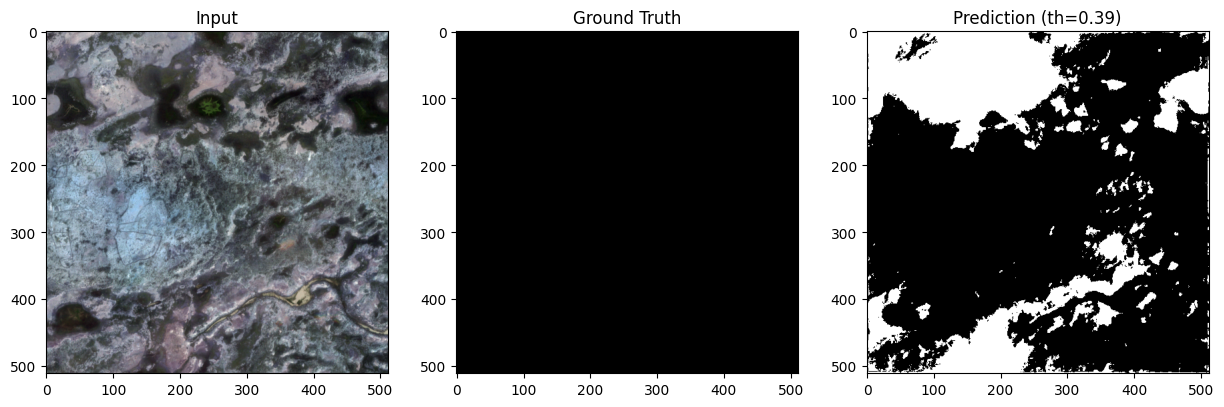

Validation: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]


Train Loss: 1.0971 | Val Loss: 0.7625
Val Dice: 0.8707±0.3660 | Threshold: 0.39
Precision: 0.9048 | Recall: 0.8737 | F1: 0.8890
New best model! Val Dice: 0.8707

Epoch 2/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]


Train Loss: 1.0001 | Val Loss: 0.8388
Val Dice: 0.8723±0.4061 | Threshold: 0.56
Precision: 0.8627 | Recall: 0.9085 | F1: 0.8850
New best model! Val Dice: 0.8723

Epoch 3/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]


Train Loss: 0.9054 | Val Loss: 0.7515
Val Dice: 0.8947±0.3974 | Threshold: 0.56
Precision: 0.9077 | Recall: 0.9130 | F1: 0.9103
New best model! Val Dice: 0.8947

Epoch 4/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


Train Loss: 0.8685 | Val Loss: 0.7396
Val Dice: 0.9003±0.3854 | Threshold: 0.48
Precision: 0.8872 | Recall: 0.9311 | F1: 0.9086
New best model! Val Dice: 0.9003

Epoch 5/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


Train Loss: 0.8300 | Val Loss: 0.7232
Val Dice: 0.8982±0.4005 | Threshold: 0.52
Precision: 0.8911 | Recall: 0.9190 | F1: 0.9048

Epoch 6/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


Train Loss: 0.8239 | Val Loss: 0.6879
Val Dice: 0.9283±0.3779 | Threshold: 0.52
Precision: 0.9224 | Recall: 0.9423 | F1: 0.9323
New best model! Val Dice: 0.9283

Epoch 7/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


Train Loss: 0.8514 | Val Loss: 0.6801
Val Dice: 0.9139±0.3695 | Threshold: 0.44
Precision: 0.9008 | Recall: 0.9413 | F1: 0.9206

Epoch 8/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


Train Loss: 0.8143 | Val Loss: 0.6801
Val Dice: 0.9108±0.3734 | Threshold: 0.56
Precision: 0.9183 | Recall: 0.9180 | F1: 0.9181

Epoch 9/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


Train Loss: 0.7684 | Val Loss: 0.7355
Val Dice: 0.8850±0.3596 | Threshold: 0.48
Precision: 0.8754 | Recall: 0.9098 | F1: 0.8923

Epoch 10/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


Train Loss: 0.7849 | Val Loss: 0.6460
Val Dice: 0.9293±0.3864 | Threshold: 0.44
Precision: 0.9322 | Recall: 0.9364 | F1: 0.9343
New best model! Val Dice: 0.9293

Epoch 11/50


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

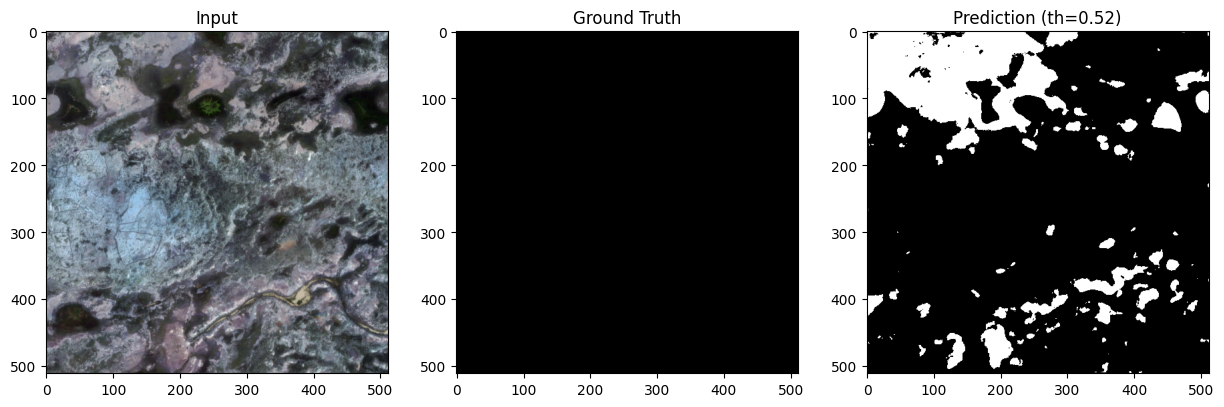

Validation: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


Train Loss: 0.7537 | Val Loss: 0.6929
Val Dice: 0.9057±0.3843 | Threshold: 0.52
Precision: 0.8899 | Recall: 0.9296 | F1: 0.9093

Epoch 12/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


Train Loss: 0.7991 | Val Loss: 0.7016
Val Dice: 0.9090±0.3959 | Threshold: 0.48
Precision: 0.9065 | Recall: 0.9173 | F1: 0.9119

Epoch 13/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.79it/s]


Train Loss: 0.7492 | Val Loss: 0.6200
Val Dice: 0.9418±0.3735 | Threshold: 0.52
Precision: 0.9443 | Recall: 0.9462 | F1: 0.9453
New best model! Val Dice: 0.9418

Epoch 14/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]


Train Loss: 0.7114 | Val Loss: 0.6727
Val Dice: 0.9341±0.3765 | Threshold: 0.48
Precision: 0.9396 | Recall: 0.9261 | F1: 0.9328

Epoch 15/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]


Train Loss: 0.6875 | Val Loss: 0.6201
Val Dice: 0.9309±0.3520 | Threshold: 0.44
Precision: 0.9259 | Recall: 0.9514 | F1: 0.9385

Epoch 16/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]


Train Loss: 0.6996 | Val Loss: 0.5821
Val Dice: 0.9462±0.3781 | Threshold: 0.48
Precision: 0.9524 | Recall: 0.9463 | F1: 0.9493
New best model! Val Dice: 0.9462

Epoch 17/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]


Train Loss: 0.7077 | Val Loss: 0.5844
Val Dice: 0.9523±0.3914 | Threshold: 0.48
Precision: 0.9557 | Recall: 0.9515 | F1: 0.9536
New best model! Val Dice: 0.9523

Epoch 18/50


Validation: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]


Train Loss: 0.6978 | Val Loss: 0.6026
Val Dice: 0.9267±0.3392 | Threshold: 0.48
Precision: 0.9207 | Recall: 0.9442 | F1: 0.9323

Epoch 19/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


Train Loss: 0.6975 | Val Loss: 0.5830
Val Dice: 0.9349±0.3404 | Threshold: 0.35
Precision: 0.9369 | Recall: 0.9463 | F1: 0.9416

Epoch 20/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.79it/s]


Train Loss: 0.6804 | Val Loss: 0.5930
Val Dice: 0.9338±0.3361 | Threshold: 0.48
Precision: 0.9279 | Recall: 0.9459 | F1: 0.9368

Epoch 21/50


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

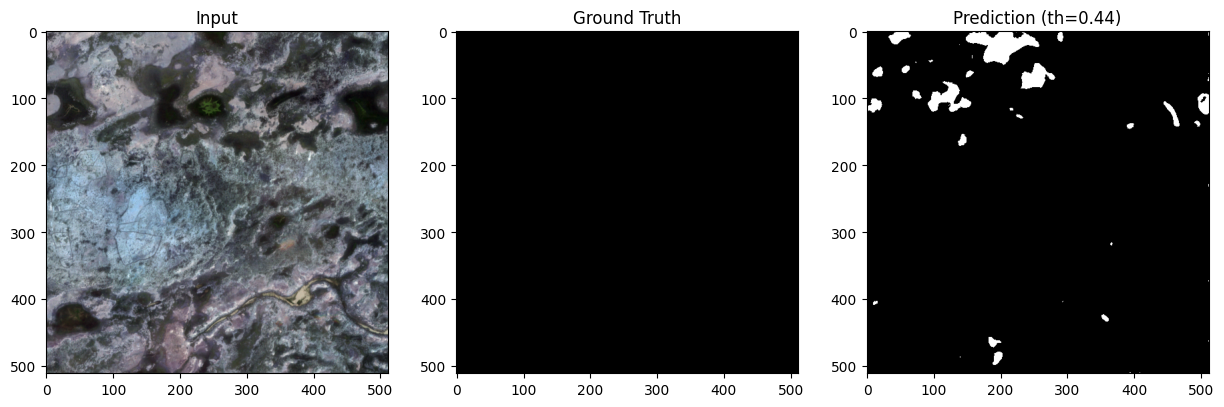

Validation: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Train Loss: 0.6780 | Val Loss: 0.5968
Val Dice: 0.9397±0.3692 | Threshold: 0.44
Precision: 0.9356 | Recall: 0.9483 | F1: 0.9419

Epoch 22/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]


Train Loss: 0.6645 | Val Loss: 0.5885
Val Dice: 0.9370±0.3521 | Threshold: 0.39
Precision: 0.9427 | Recall: 0.9358 | F1: 0.9393

Epoch 23/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.96it/s]


Train Loss: 0.6234 | Val Loss: 0.5962
Val Dice: 0.9404±0.3652 | Threshold: 0.52
Precision: 0.9548 | Recall: 0.9281 | F1: 0.9412

Epoch 24/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]


Train Loss: 0.6322 | Val Loss: 0.5671
Val Dice: 0.9416±0.3634 | Threshold: 0.35
Precision: 0.9410 | Recall: 0.9517 | F1: 0.9463

Epoch 25/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


Train Loss: 0.6137 | Val Loss: 0.5619
Val Dice: 0.9471±0.3363 | Threshold: 0.39
Precision: 0.9517 | Recall: 0.9486 | F1: 0.9502

Epoch 26/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


Train Loss: 0.5962 | Val Loss: 0.5791
Val Dice: 0.9344±0.3360 | Threshold: 0.39
Precision: 0.9208 | Recall: 0.9570 | F1: 0.9385

Epoch 27/50


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]


Train Loss: 0.6358 | Val Loss: 0.5697
Val Dice: 0.9403±0.3533 | Threshold: 0.69
Precision: 0.9371 | Recall: 0.9582 | F1: 0.9475
No improvement for 10 epochs. Early stopping!

Evaluating on test set...


Validation:   0%|          | 0/55 [00:00<?, ?it/s]

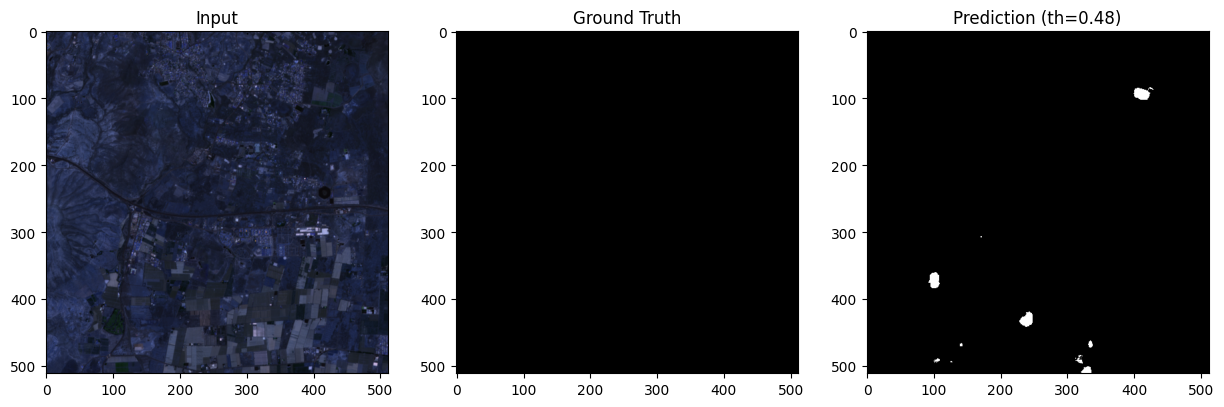

Validation: 100%|██████████| 55/55 [00:05<00:00, 10.37it/s]



--- Test Metrics ---
Validation Threshold Used: 0.48
Test Loss: 0.6677
Test Dice: 0.7083±0.3866
Test IoU: 0.6623±0.3850
Precision: 0.9410 | Recall: 0.8965 | F1: 0.9182


In [9]:
torch.multiprocessing.set_sharing_strategy('file_system')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    train_model()
except Exception as e:
    print(f"Critical error: {e}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TESTONLY = False  # Set to True for testing only
if TESTONLY:
    batch_size = 4

    try:
        train_set, val_set, test_set = prepare_datasets('../data/processed')
    except Exception as e:
        print(f"Error preparing datasets: {e}")
        exit(1)

    pos_weight_value = compute_pos_weight(train_set)
    pos_weight = torch.tensor([pos_weight_value]).to(device)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

    model = UNet(n_channels=4, n_classes=1).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    dice = DiceLoss()

    def combined_loss_fn(logits, targets):
        return bce(logits, targets) + dice(logits, targets)

    criterion = combined_loss_fn

    test_model(model, test_loader, criterion, device)